Q1 PART 1

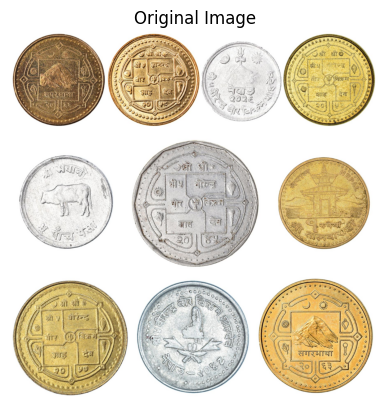

In [2]:
###22i-2034 SOHAIB SHAHZAD DS-A
import cv2
import numpy as np
import matplotlib.pyplot as plt


img = cv2.imread("coins.jpg")

# Convert to RGB 
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


plt.imshow(img_rgb)
plt.title("Original Image")
plt.axis("off")
plt.show()


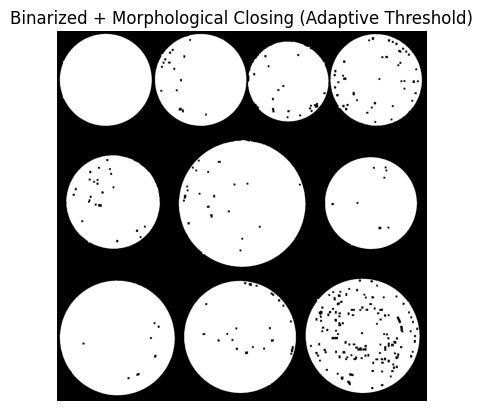

In [3]:
# Step 2: Convert to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

#  blur to reduce noise
blurred = cv2.GaussianBlur(gray, (5, 5), 0)

# Step 3: Adaptive Threshold
#  cv2.ADAPTIVE_THRESH_GAUSSIAN_C with THRESH_BINARY_INV
# blockSize=11 and C=2 are typical starting values
binary = cv2.adaptiveThreshold(
    blurred, 255,
    cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    cv2.THRESH_BINARY_INV,
    11,  # blockSize: size of the neighborhood area
    2    # C: constant subtracted from the mean
)

# Step 4: Morphological Closing to fill holes in the coins
kernel = np.ones((5, 5), np.uint8)
closed = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel, iterations=2)


plt.imshow(closed, cmap='gray')
plt.title("Binarized + Morphological Closing (Adaptive Threshold)")
plt.axis("off")
plt.show()

#  'closed' for subsequent connected component labeling
binary = closed


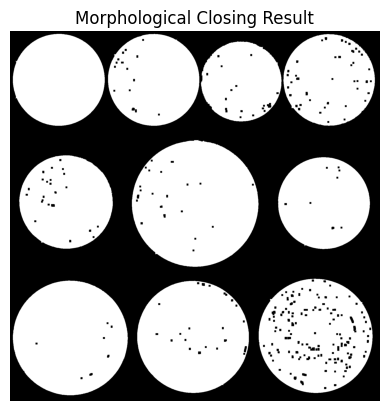

In [4]:
# a structuring element (kernel) for morphological operations
kernel = np.ones((5, 5), np.uint8)

#  Perform closing (dilation followed by erosion) to fill small holes
closed = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel, iterations=2)



# For demonstration, we'll stick with 'closed' as the final result
morph_result = closed



#  display the result:
import matplotlib.pyplot as plt
plt.imshow(morph_result, cmap='gray')
plt.title("Morphological Closing Result")
plt.axis("off")
plt.show()


In [5]:
def connected_component_labeling(binary_img):
    
    # 1) Convert all non-zero pixels to 1 for easier processing
    bw = (binary_img > 0).astype(np.uint8)
    rows, cols = bw.shape
    
    # 2) Initialize labels array
    labels = np.zeros((rows, cols), dtype=np.int32)
    current_label = 0
    
    # -------------------------
    # First pass
    # -------------------------
    for r in range(rows):
        for c in range(cols):
            if bw[r, c] == 1:
                # Check left and up neighbors
                left_label = labels[r, c-1] if c-1 >= 0 else 0
                up_label   = labels[r-1, c] if r-1 >= 0 else 0
                
                if left_label == 0 and up_label == 0:
                    # New component
                    current_label += 1
                    labels[r, c] = current_label
                elif left_label != 0 and up_label == 0:
                    labels[r, c] = left_label
                elif left_label == 0 and up_label != 0:
                    labels[r, c] = up_label
                else:
                    # Both neighbors have labels; take the smaller one
                    labels[r, c] = min(left_label, up_label)
    
    
   
    label_equiv = {}
    for label_val in range(1, current_label + 1):
        label_equiv[label_val] = label_val  # initialize equivalence
    
    for r in range(rows):
        for c in range(cols):
            if labels[r, c] != 0:
                left_label = labels[r, c-1] if c-1 >= 0 else 0
                up_label   = labels[r-1, c] if r-1 >= 0 else 0
                cur_label  = labels[r, c]
                
                # Unify with left neighbor if needed
                if left_label != 0 and left_label != cur_label:
                    small = min(label_equiv[cur_label], label_equiv[left_label])
                    large = max(label_equiv[cur_label], label_equiv[left_label])
                    for k in label_equiv:
                        if label_equiv[k] == large:
                            label_equiv[k] = small
                
                # Unify with up neighbor if needed
                if up_label != 0 and up_label != cur_label:
                    small = min(label_equiv[cur_label], label_equiv[up_label])
                    large = max(label_equiv[cur_label], label_equiv[up_label])
                    for k in label_equiv:
                        if label_equiv[k] == large:
                            label_equiv[k] = small
    
    # resolved equivalences
    for r in range(rows):
        for c in range(cols):
            if labels[r, c] != 0:
                labels[r, c] = label_equiv[labels[r, c]]
    
    # Re-label to ensure labels are consecutive (1, 2, 3, …)
    unique_labels = np.unique(labels)
    unique_labels = unique_labels[unique_labels != 0]  # remove background (0)
    new_label_map = {}
    new_idx = 1
    for ul in unique_labels:
        new_label_map[ul] = new_idx
        new_idx += 1
    for r in range(rows):
        for c in range(cols):
            if labels[r, c] != 0:
                labels[r, c] = new_label_map[labels[r, c]]
    
    num_components = len(unique_labels)
    return labels, num_components


# Run connected component labeling
labels, num_components = connected_component_labeling(morph_result)
print("Number of connected components found:", num_components)

# -------------------------
# Filtering Step (by Area)
# -------------------------
min_area = 500  # Adjust this value based on your coin sizes
filtered_labels = np.zeros_like(labels)
new_label = 0

for label_val in range(1, num_components + 1):
    # Get pixel coordinates for the current component
    coords = np.where(labels == label_val)
    area = len(coords[0])
    
    if area >= min_area:
        new_label += 1
        filtered_labels[coords] = new_label

num_filtered_components = new_label
print("Filtered number of connected components (coins):", num_filtered_components)


Number of connected components found: 13
Filtered number of connected components (coins): 10


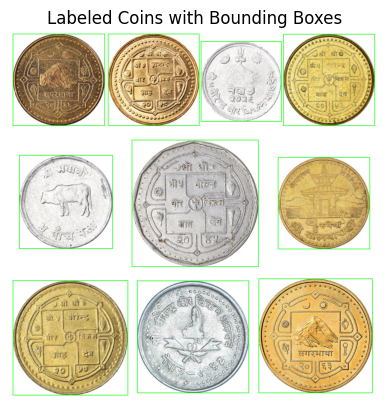

In [6]:
# the original image to draw bounding boxes
img_with_boxes = img.copy()


bounding_boxes = []

# Loop over each component label (starting from 1 to num_filtered_components)
for label_val in range(1, num_filtered_components + 1):
    # the pixel coordinates (rows, cols) for this label
    ys, xs = np.where(filtered_labels == label_val)
    
    if len(xs) == 0 or len(ys) == 0:
        continue  #  if no pixels found
    
    #  the bounding box coordinates
    x_min, x_max = np.min(xs), np.max(xs)
    y_min, y_max = np.min(ys), np.max(ys)
    bounding_boxes.append((x_min, y_min, x_max, y_max))
    
    #  the rectangle on the image (using green color and thickness 2)
    cv2.rectangle(img_with_boxes, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)


img_with_boxes_rgb = cv2.cvtColor(img_with_boxes, cv2.COLOR_BGR2RGB)
plt.imshow(img_with_boxes_rgb)
plt.title("Labeled Coins with Bounding Boxes")
plt.axis("off")
plt.show()


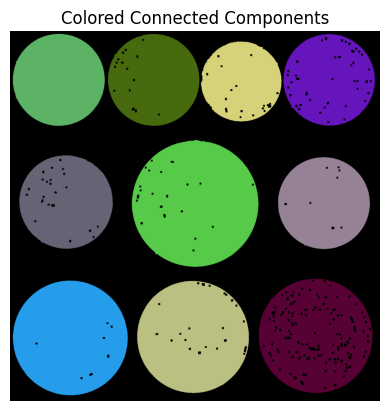

In [7]:
#  an empty color image with the same height and width as filtered_labels.
color_image = np.zeros((filtered_labels.shape[0], filtered_labels.shape[1], 3), dtype=np.uint8)

#  a random color to each component. We'll use the number of filtered components.
np.random.seed(42)  # for reproducibility
colors = {}

# Generate a random color for each label (1 to num_filtered_components)
for label_val in range(1, num_filtered_components + 1):
    colors[label_val] = np.random.randint(0, 255, size=3)

# Map each pixel in filtered_labels to its corresponding random color.
for r in range(filtered_labels.shape[0]):
    for c in range(filtered_labels.shape[1]):
        label_val = filtered_labels[r, c]
        if label_val > 0:
            color_image[r, c] = colors[label_val]

#  color image from BGR to RGB (if needed for matplotlib display)
plt.imshow(cv2.cvtColor(color_image, cv2.COLOR_BGR2RGB))
plt.title("Colored Connected Components")
plt.axis("off")
plt.show()


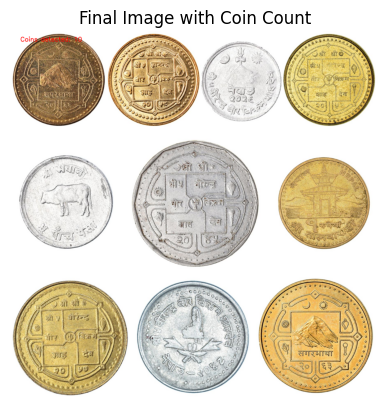

Number of coins detected: 10
Images saved successfully.


In [8]:

# Create a copy of the original image to annotate with the coin count
final_img = img.copy()
coin_count_text = f"Coins detected: {num_filtered_components}"

# Put text on the final image using OpenCV
cv2.putText(final_img, coin_count_text, (50, 50), 
            cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

# Convert final image to RGB and display
final_img_rgb = cv2.cvtColor(final_img, cv2.COLOR_BGR2RGB)
plt.imshow(final_img_rgb)
plt.title("Final Image with Coin Count")
plt.axis("off")
plt.show()

# Print the number of coins detected to the console
print("Number of coins detected:", num_filtered_components)

# --- Saving Images at Different Stages ---
cv2.imwrite("original_image.jpg", img)
cv2.imwrite("binary_image.jpg", morph_result)        # Processed binary image
cv2.imwrite("bounding_boxes.jpg", img_with_boxes)      # Image with bounding boxes
cv2.imwrite("colored_components.jpg", color_image)     # Image with colored connected components
cv2.imwrite("final_annotated.jpg", final_img)          # Final image with coin count annotation

print("Images saved successfully.")


#part 2

Image loaded successfully. Shape: (655, 1140, 3)
Number of cars found: 14


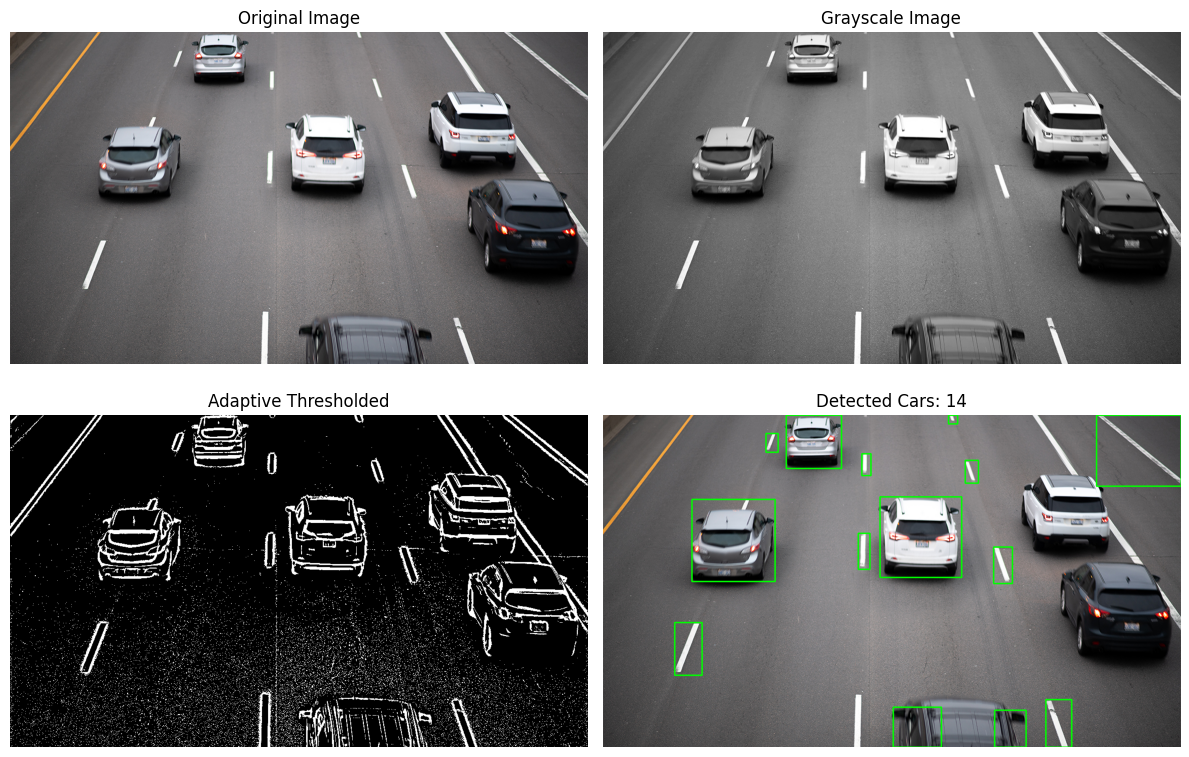

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Load the image
img_path = "car.jpg"
image = cv2.imread(img_path)
if image is None:
    print(f"Error: Could not load image from {img_path}.")
    exit()

print("Image loaded successfully. Shape:", image.shape)

# Convert to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply Adaptive Thresholding (better for lighting variations)
binary = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                               cv2.THRESH_BINARY_INV, 21, 9)

# Morphological operations to clean up noise and connect car regions
kernel_open = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
opened = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel_open, iterations=1)

kernel_close = cv2.getStructuringElement(cv2.MORPH_RECT, (10, 10))
closed = cv2.morphologyEx(opened, cv2.MORPH_CLOSE, kernel_close, iterations=2)

# Find contours
contours, _ = cv2.findContours(closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Define area and aspect ratio thresholds for filtering valid cars
min_area = 250  # Lowered to detect smaller cars
max_area = 30000  # Increased to allow larger vehicles
min_aspect_ratio = 0.3
max_aspect_ratio = 3.5

car_count = 0
output_image = image.copy()

for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    area = w * h
    aspect_ratio = w / float(h)
    
    # Filter valid car-like objects
    if min_area < area < max_area and min_aspect_ratio < aspect_ratio < max_aspect_ratio:
        car_count += 1
        cv2.rectangle(output_image, (x, y), (x + w, y + h), (0, 255, 0), 2)

print("Number of cars found:", car_count)

# Display results inline
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

axs[0, 0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
axs[0, 0].set_title("Original Image")
axs[0, 0].axis("off")

axs[0, 1].imshow(gray, cmap="gray")
axs[0, 1].set_title("Grayscale Image")
axs[0, 1].axis("off")

axs[1, 0].imshow(binary, cmap="gray")
axs[1, 0].set_title("Adaptive Thresholded")
axs[1, 0].axis("off")

axs[1, 1].imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
axs[1, 1].set_title(f"Detected Cars: {car_count}")
axs[1, 1].axis("off")

plt.tight_layout()
plt.show()


#PART 3

Number of characters detected (filtered): 20


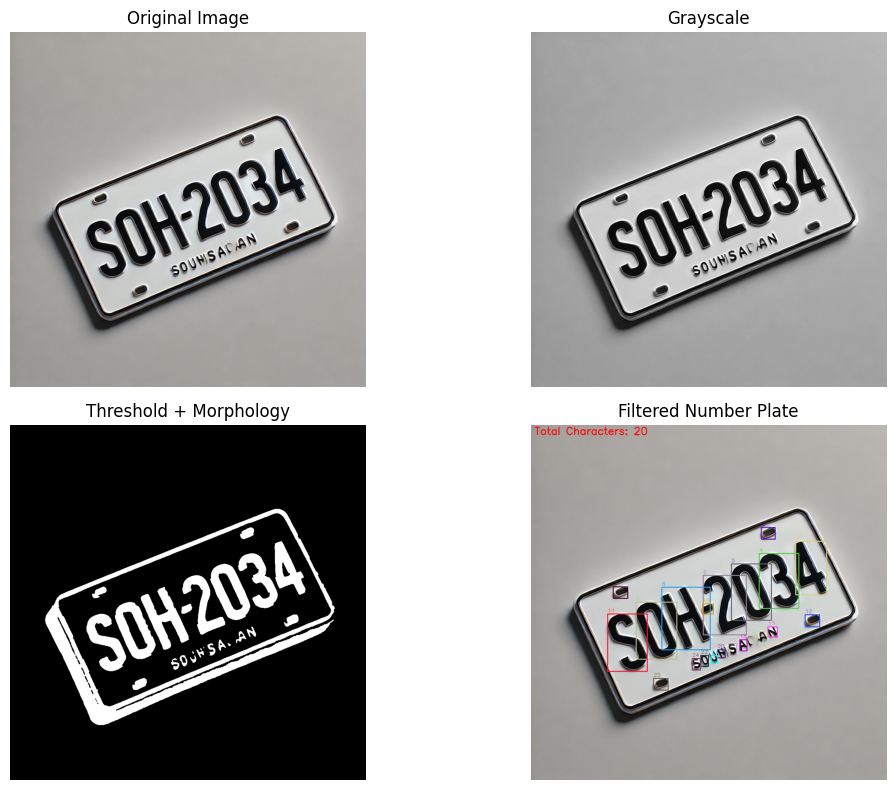

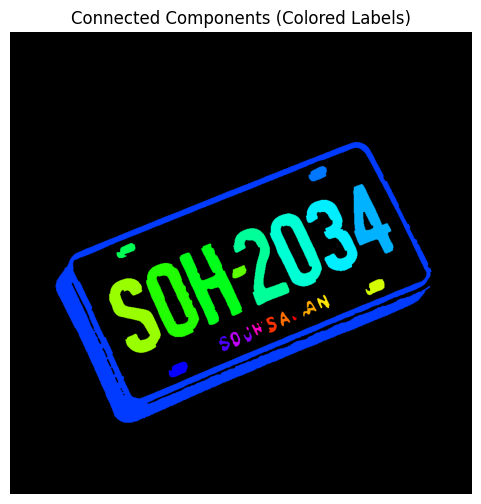

In [12]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------------------------------------------
# 1) MORE LENIENT PARAMETERS
# -----------------------------------------------------------------
# Try reducing the minimum area so smaller characters aren’t discarded
# and increasing the maximum area so large letters aren’t excluded.
MIN_AREA = 100
MAX_AREA = 10000

# Relax bounding-box height constraints so small or large characters aren't excluded
MIN_HEIGHT = 20
MAX_HEIGHT = 200

# Allow a wider aspect ratio range to include thin/wide characters (dash) or tall ones
ASPECT_RATIO_MIN = 0.1
ASPECT_RATIO_MAX = 4.0

# Morphological operations: smaller kernels, fewer iterations
KERNEL_CLOSE_SIZE = (3, 3)
CLOSE_ITER = 1
KERNEL_OPEN_SIZE  = (3, 3)
OPEN_ITER = 1

# Disable vertical filtering entirely for now
USE_VERTICAL_FILTER = False
Y_LOW_FRAC  = 0.0
Y_HIGH_FRAC = 1.0

# -----------------------------------------------------------------
# 2) LOAD THE IMAGE
# -----------------------------------------------------------------
img = cv2.imread('plate.webp', cv2.IMREAD_COLOR)
if img is None:
    print("Error: Could not load image. Check file path/format/OpenCV build.")
    exit()

# Convert to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# -----------------------------------------------------------------
# 3) THRESHOLD (OTSU + BINARY INVERSION)
# -----------------------------------------------------------------
_, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# -----------------------------------------------------------------
# 4) MORPHOLOGICAL OPERATIONS
# -----------------------------------------------------------------
# Closing: merge disconnected parts of each character, fill small holes
kernel_close = cv2.getStructuringElement(cv2.MORPH_RECT, KERNEL_CLOSE_SIZE)
thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel_close, iterations=CLOSE_ITER)

# Opening: remove small noise around characters
kernel_open = cv2.getStructuringElement(cv2.MORPH_RECT, KERNEL_OPEN_SIZE)
thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel_open, iterations=OPEN_ITER)

# -----------------------------------------------------------------
# 5) CONNECTED COMPONENTS
# -----------------------------------------------------------------
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(thresh, connectivity=8)

height, width = gray.shape
valid_labels = []

# Since vertical filtering is off, these cutoffs won't be used
y_min_cut = int(Y_LOW_FRAC * height)
y_max_cut = int(Y_HIGH_FRAC * height)

for label_id in range(1, num_labels):  # skip background = 0
    area = stats[label_id, cv2.CC_STAT_AREA]
    x = stats[label_id, cv2.CC_STAT_LEFT]
    y = stats[label_id, cv2.CC_STAT_TOP]
    w = stats[label_id, cv2.CC_STAT_WIDTH]
    h = stats[label_id, cv2.CC_STAT_HEIGHT]

    # 1) Filter by area
    if area < MIN_AREA or area > MAX_AREA:
        continue

    # 2) Filter by bounding-box height
    if h < MIN_HEIGHT or h > MAX_HEIGHT:
        continue

    # 3) Filter by aspect ratio
    ratio = w / float(h) if h != 0 else 0
    if ratio < ASPECT_RATIO_MIN or ratio > ASPECT_RATIO_MAX:
        continue

    # 4) (Disabled) Vertical position filter
    if USE_VERTICAL_FILTER:
        if (y + h) < y_min_cut or y > y_max_cut:
            continue

    valid_labels.append(label_id)

num_characters = len(valid_labels)
print("Number of characters detected (filtered):", num_characters)

# -----------------------------------------------------------------
# 6) VISUALIZATION
# -----------------------------------------------------------------
# Create a colored label image for debugging
label_hue = np.uint8(179 * labels / np.max(labels))
blank_channel = 255 * np.ones_like(label_hue)
labeled_img_hsv = cv2.merge([label_hue, blank_channel, blank_channel])
labeled_img = cv2.cvtColor(labeled_img_hsv, cv2.COLOR_HSV2BGR)
labeled_img[label_hue == 0] = 0  # background -> black

# Draw bounding boxes on a copy of the original
output_img = img.copy()
np.random.seed(42)
colors = [tuple(np.random.randint(0, 255, 3).tolist()) for _ in range(num_labels)]

for label_id in valid_labels:
    x = stats[label_id, cv2.CC_STAT_LEFT]
    y = stats[label_id, cv2.CC_STAT_TOP]
    w = stats[label_id, cv2.CC_STAT_WIDTH]
    h = stats[label_id, cv2.CC_STAT_HEIGHT]

    cv2.rectangle(output_img, (x, y), (x + w, y + h), colors[label_id], 2)
    cv2.putText(output_img, str(label_id), (x, y - 5),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, colors[label_id], 1)

cv2.putText(output_img, f"Total Characters: {num_characters}", (10, 30),
            cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

# -----------------------------------------------------------------
# 7) SHOW THE RESULTS
# -----------------------------------------------------------------
plt.figure(figsize=(12, 8))

# Original
plt.subplot(2, 2, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

# Grayscale
plt.subplot(2, 2, 2)
plt.imshow(gray, cmap='gray')
plt.title('Grayscale')
plt.axis('off')

# Thresholded (after morphology)
plt.subplot(2, 2, 3)
plt.imshow(thresh, cmap='gray')
plt.title('Threshold + Morphology')
plt.axis('off')

# Labeled & Filtered
plt.subplot(2, 2, 4)
plt.imshow(cv2.cvtColor(output_img, cv2.COLOR_BGR2RGB))
plt.title('Filtered Number Plate')
plt.axis('off')

plt.tight_layout()
plt.show()

# (Optional) Show the colored label image
plt.figure(figsize=(6, 6))
plt.imshow(labeled_img)
plt.title('Connected Components (Colored Labels)')
plt.axis('off')
plt.show()


In [13]:
#part 4

Q2 

Justification for Using 1 Bit:

Minimal Visual Impact:
Using only 1 Least Significant Bit (LSB) per color channel ensures that the change in pixel value is very small (only 1 out of 256 possible values in an 8-bit channel). This change is usually imperceptible to the human eye, thus preserving the original image quality.

Sufficient Capacity for Small Messages:
For short text messages, 1 bit per pixel is generally sufficient. The slight capacity provided by 1 bit is enough to embed the message along with any necessary metadata (like the message length) without overloading the image.

Lower Risk of Detection:
By altering only the least significant bit, the overall appearance of the image remains almost unchanged, reducing the risk that someone will notice any anomalies or suspect that a hidden message exists.

Trade-off Consideration:
While using 2 bits per pixel would increase the capacity for larger messages, it also increases the likelihood of introducing noticeable distortions in the image. For applications where image fidelity is important, especially in something as personal as a selfie, it’s ideal to minimize any changes that could degrade the image quality.

Overall, using 1 bit strikes an optimal balance between hiding enough data for the intended message and maintaining the original image’s visual integrity.

Justification:

1 bit changes each pixel’s color value by at most 1 (in decimal), so the difference is usually invisible. This is good for smaller messages.
2 bits can store double the data but might cause slight color variations in uniform areas.

In [17]:
###22i-2034 SOHAIB SHAHZAD DS-A

import cv2
import numpy as np
import matplotlib.pyplot as plt

# ============================================================
# Global Helper Functions for Text Steganography (Options 1 & 2)
# ============================================================

def text_to_binary(message):
    
    return ''.join([format(ord(c), '08b') for c in message])

def binary_to_text(binary_str):
  
    chars = []
    for i in range(0, len(binary_str), 8):
        byte = binary_str[i:i+8]
        chars.append(chr(int(byte, 2)))
    return ''.join(chars)

def encode_text_in_image(img, secret_text, bits=1):
    
    encoded_img = img.copy()  # Work on a copy
    h, w, c = encoded_img.shape
    total_pixels = h * w * c

    secret_bin = text_to_binary(secret_text)
    msg_len = len(secret_bin)
    msg_len_bin = format(msg_len, '032b')  # 32-bit length header

    data_to_hide = msg_len_bin + secret_bin

    if bits * total_pixels < len(data_to_hide):
        raise ValueError("Not enough capacity in the image to hide the message with {} bits.".format(bits))

    flat_img = encoded_img.reshape(-1)
    for i in range(len(data_to_hide)):
        pixel_val = flat_img[i]
        pixel_bin = format(pixel_val, '08b')
        new_pixel_bin = pixel_bin[:-bits] + data_to_hide[i:i+bits]
        flat_img[i] = int(new_pixel_bin, 2)
    encoded_img = flat_img.reshape(h, w, c)
    return encoded_img

def decode_text_from_image(img, bits=1):
    
    h, w, c = img.shape
    flat_img = img.reshape(-1)

    length_bin = ""
    for i in range(32):
        pixel_val = flat_img[i]
        pixel_bin = format(pixel_val, '08b')
        length_bin += pixel_bin[-bits:]
    msg_length = int(length_bin, 2)

    message_bits = ""
    for i in range(32, 32 + msg_length):
        pixel_val = flat_img[i]
        pixel_bin = format(pixel_val, '08b')
        message_bits += pixel_bin[-bits:]
    hidden_text = binary_to_text(message_bits)
    return hidden_text

# ============================================================
# Option 1: Capture Selfie and Hide/Extract Text Message
# ============================================================

def option1():
    # --- Capture a Selfie ---
    cap = cv2.VideoCapture(0)
    if not cap.isOpened():
        print("Could not open webcam")
        return
    print("Webcam opened successfully")
    ret, frame = cap.read()
    if ret:
        cv2.imwrite('selfie.jpg', frame)
        print("Selfie captured and saved as 'selfie.jpg'.")
    else:
        print("Failed to capture an image from the webcam.")
        cap.release()
        return
    cap.release()
    cv2.destroyAllWindows()

    # --- Hide a Text Message in the Selfie ---
    original_image = cv2.imread('selfie.jpg')
    if original_image is None:
        print("Error: Could not load 'selfie.jpg'.")
        return
    original_image_rgb = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

    # You can change the secret message or even prompt the user
    secret_message = "  secret  code  !!!!"
    stego_image_rgb = encode_text_in_image(original_image_rgb, secret_message, bits=1)
    print("Secret message embedded successfully!")

    # --- Display Original and Stego Images ---
    plt.figure(figsize=(12,6))
    plt.subplot(1,2,1)
    plt.imshow(original_image_rgb)
    plt.title("Original Selfie")
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.imshow(stego_image_rgb)
    plt.title("Stego Selfie (Message Hidden)")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

    # --- Extract and Display the Hidden Message ---
    recovered_message = decode_text_from_image(stego_image_rgb, bits=1)
    print("Recovered Hidden Message:", recovered_message)

# ============================================================
# Option 2: Hide and Extract Text in Any Image
# ============================================================

def option2():
    image_path = input("Enter the path to your image (e.g., 'image.jpg'): ")
    secret_message = input("Enter the text you want to hide: ")
    bits_to_use = 1
    print(f"Using {bits_to_use} bit(s) for LSB steganography.")

    original_image = cv2.imread(image_path)
    if original_image is None:
        print("Error: Could not load the image. Check the file path.")
        return
    original_image_rgb = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

    stego_image_rgb = encode_text_in_image(original_image_rgb, secret_message, bits=bits_to_use)
    print("Message hidden successfully in the image.")

    plt.figure(figsize=(12,6))
    plt.subplot(1,2,1)
    plt.imshow(original_image_rgb)
    plt.title("Original Image")
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.imshow(stego_image_rgb)
    plt.title("Stego Image (Message Hidden)")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

    recovered_message = decode_text_from_image(stego_image_rgb, bits=bits_to_use)
    print("Recovered Hidden Message:", recovered_message)

# ============================================================
# Option 3: Hide and Extract an Image Inside Another Image
# ============================================================

def option3():
    cover_path = input("Enter the cover image file path (e.g., 'cover.webp'): ")
    secret_path = input("Enter the secret image file path (e.g., 'secret.webp'): ")

    cover_img = cv2.imread(cover_path)
    if cover_img is None:
        print("Error: Unable to load cover image.")
        return
    secret_img = cv2.imread(secret_path)
    if secret_img is None:
        print("Error: Unable to load secret image.")
        return

    # Resize secret image if dimensions differ
    if cover_img.shape != secret_img.shape:
        secret_img = cv2.resize(secret_img, (cover_img.shape[1], cover_img.shape[0]))
        print("Secret image has been resized to match the cover image dimensions.")

    # --- Hiding Process ---
    # Clear last 2 bits of cover image
    cover_cleared = cover_img & 0xFC  # 0xFC = 11111100
    # Extract the 2 most significant bits from secret image
    secret_bits = secret_img >> 6
    # Combine to embed secret image into cover image
    hidden_img = cover_cleared | secret_bits

    # Convert for display (BGR -> RGB)
    cover_img_rgb = cv2.cvtColor(cover_img, cv2.COLOR_BGR2RGB)
    secret_img_rgb = cv2.cvtColor(secret_img, cv2.COLOR_BGR2RGB)
    hidden_img_rgb = cv2.cvtColor(hidden_img, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(18,6))
    plt.subplot(1,3,1)
    plt.imshow(cover_img_rgb)
    plt.title("Cover Image")
    plt.axis("off")
    plt.subplot(1,3,2)
    plt.imshow(secret_img_rgb)
    plt.title("Secret Image")
    plt.axis("off")
    plt.subplot(1,3,3)
    plt.imshow(hidden_img_rgb)
    plt.title("Hidden Image (Secret embedded)")
    plt.axis("off")
    plt.tight_layout()
    plt.show()

    # --- Extraction Process ---
    extracted_secret_bits = hidden_img & 0x03  # 0x03 = 00000011 (last 2 bits)
    # Scale the bits to full intensity range (0,85,170,255)
    extracted_secret = extracted_secret_bits * 85
    extracted_secret_rgb = cv2.cvtColor(extracted_secret, cv2.COLOR_BGR2RGB)
    
    plt.figure(figsize=(8,6))
    plt.imshow(extracted_secret_rgb)
    plt.title("Extracted Secret Image")
    plt.axis("off")
    plt.show()

# ============================================================
# Option 4: Superimpose Two Images Using 4 Bits Each
# ============================================================

def option4():
    img1_path = input("Enter the path or name of the first image (e.g., 'image1.webp'): ")
    img2_path = input("Enter the path or name of the second image (e.g., 'image2.webp'): ")

    img1 = cv2.imread(img1_path)
    if img1 is None:
        print("Error: Unable to load the first image.")
        return
    img2 = cv2.imread(img2_path)
    if img2 is None:
        print("Error: Unable to load the second image.")
        return

    img1_rgb = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
    img2_rgb = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(12,6))
    plt.subplot(1,2,1)
    plt.imshow(img1_rgb)
    plt.title("Image 1")
    plt.axis("off")
    plt.subplot(1,2,2)
    plt.imshow(img2_rgb)
    plt.title("Image 2")
    plt.axis("off")
    plt.tight_layout()
    plt.show()

    # Resize img2 if dimensions differ from img1
    if img1.shape != img2.shape:
        img2 = cv2.resize(img2, (img1.shape[1], img1.shape[0]))

    # Clear lower 4 bits of image 1 and extract upper 4 bits of image 2
    img1_upper = img1 & 0xF0       # 0xF0 = 11110000
    img2_upper = (img2 & 0xF0) >> 4  # Shift right by 4 bits
    superimposed = img1_upper | img2_upper

    superimposed_rgb = cv2.cvtColor(superimposed, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(8,6))
    plt.imshow(superimposed_rgb)
    plt.title("Superimposed Image")
    plt.axis("off")
    plt.show()

# ============================================================
# Main Menu-Driven Program
# ============================================================

def main():
    while True:
        print("\nMenu:")
        print("1. Capture Selfie and Hide/Extract Text Message")
        print("2. Hide/Extract Text in any Image")
        print("3. Hide and Extract an Image inside another Image")
        print("4. Superimpose Two Images using 4 Bits each")
        print("5. Exit")
        choice = input("Enter your choice (1-5): ")
        if choice == '1':
            option1()
        elif choice == '2':
            option2()
        elif choice == '3':
            option3()
        elif choice == '4':
            option4()
        elif choice == '5':
            print("Exiting the program.")
            break
        else:
            print("Invalid choice. Please try again.")

if __name__ == "__main__":
    main()



Menu:
1. Capture Selfie and Hide/Extract Text Message
2. Hide/Extract Text in any Image
3. Hide and Extract an Image inside another Image
4. Superimpose Two Images using 4 Bits each
5. Exit


KeyboardInterrupt: Interrupted by user